In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
from tensorflow.keras.datasets.mnist import load_data

(x_train, y_train), (x_test, y_test) = load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

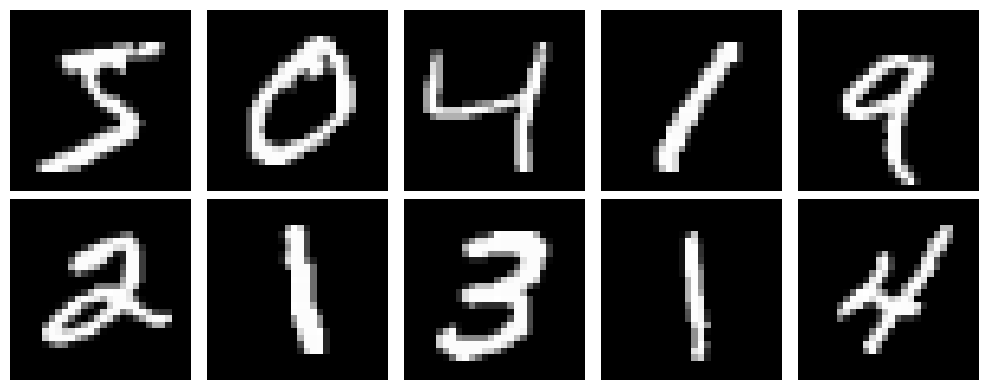

In [2]:
def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")
    fig.tight_layout()

plot_samples(x_train)

In [3]:
# plot_samples(x_train[50000])
x_train[50000].shape

(28, 28)

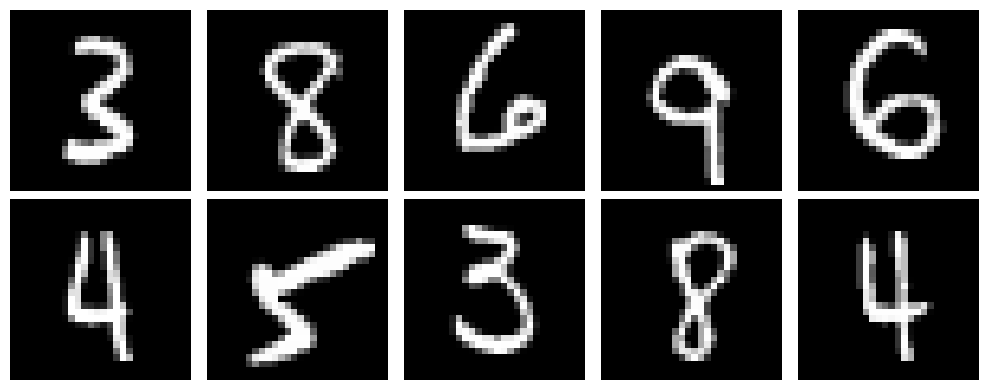

In [4]:
plot_samples(x_train[50000:50010])

In [5]:
X_train = x_train.astype("float32")/255
X_test = x_test.astype("float32")/255
X_train.min(), X_train.max()

(0.0, 1.0)

### Train|val|test split

In [6]:
from sklearn.model_selection import train_test_split

# we already have X_train: 60000 samples 
# X_train_val: 50000 samples -> training part for validation and hyperparameter tuning
# X_val: 10000 samples -> validation used for hyperparameter tuning and validation loss curves
# train on train_val and validate on val to hyperparameter tune, then when finished train on whole training data set
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1 / 6, random_state=42
)

# rank 3 
X_train_val.shape, X_val.shape

((50000, 28, 28), (10000, 28, 28))

In [7]:
# we will use ImageDataGenerator to augment our data
# it requires rank 4 e.g. (50000,28,28,3), (10000,28,28,1)
X_train_val[..., None].shape

(50000, 28, 28, 1)

In [8]:
X_train_val = X_train_val[..., None]
X_train = X_train[..., None]
X_val = X_val[..., None]
X_test = X_test[..., None]

X_train_val.shape

(50000, 28, 28, 1)

### Data augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

help(ImageDataGenerator())

Help on ImageDataGenerator in module keras.src.legacy.preprocessing.image object:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  DEPRECATED.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom

In [10]:
train_image_generator = ImageDataGenerator(rotation_range=90)

# batch size 32 - used for mini-batch gradient descent - which gives us stochasticity in backpropagation
# flow is used for regenerating images after it has been exhausted 
# this is because we will train in many epochs 
train_generator = train_image_generator.flow(X_train, y_train, batch_size=32) 

train_generator

In [11]:
# 32 gray scaled images - this is first batch
train_generator[0][0].shape

(32, 28, 28, 1)

In [12]:
train_generator[1][0].shape # 2nd batch

(32, 28, 28, 1)

In [13]:
train_generator[1][1].shape # labels for 2nd batch

(32,)

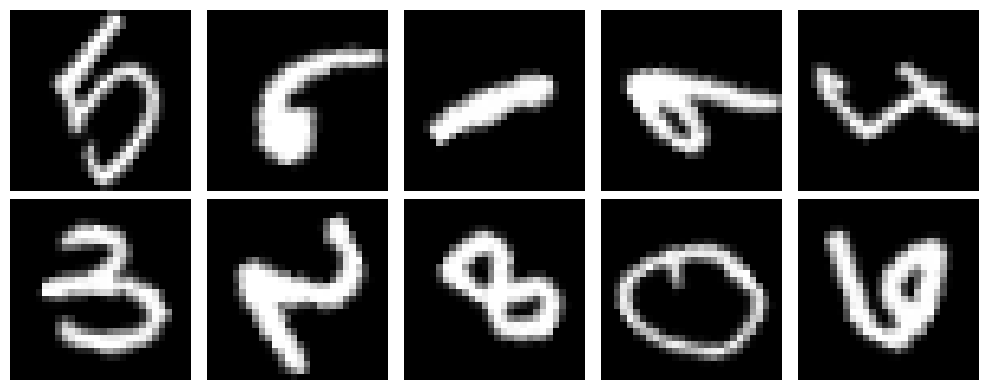

In [14]:
# illustrates what happens with up to 90° rotation
plot_samples(next(train_generator)[0])

### Make a good augmenatation

In [15]:
train_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    height_shift_range=0.1,
    width_shift_range=0.2,
)

# don't augment test data and validation data - want to test on original data
# this is used for mini-batch in training
test_image_generator = ImageDataGenerator()

train_generator = train_image_generator.flow(X_train, y_train, batch_size=32)
train_val_generator = train_image_generator.flow(X_train_val, y_train_val, batch_size=32)
val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

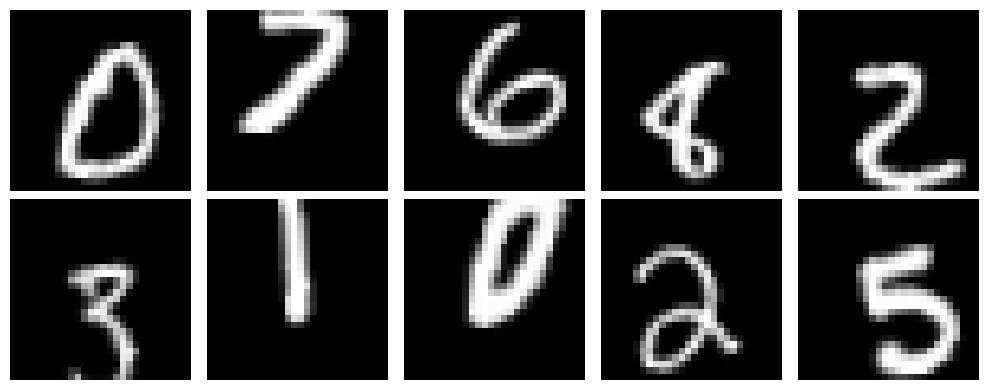

In [16]:
plot_samples(next(train_generator)[0])

### CNN model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def cnn_model(learning_rate=0.001, drop_rate=0.5, kernels=[32, 32]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

    # MLP part
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"]
    )

    return model

model = cnn_model(drop_rate=.5)

model.summary()

c:\Users\Sammy Guru\Documents\github\AI-Samir-Ibrahim-OPA23\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,194 (848.41 KB)

 Trainable params: 217,194 (848.41 KB)

 Non-trainable params: 0 (0.00 B)

### Train on augmented data

In [18]:
# number of steps for minibatch in one epoch 
steps_per_epoch = len(X_train_val)//32
validation_steps = len(X_val)//32

# number of batches to be ran in one epoch
steps_per_epoch, validation_steps

(1562, 312)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True
)

model.fit(
    train_val_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    callbacks=[early_stopper],
    validation_data = val_generator, # this will give us batches for validation
    validation_steps = validation_steps
)

Epoch 1/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 36:36 1s/step - acc: 0.0625 - loss: 3.0546

c:\Users\Sammy Guru\Documents\github\AI-Samir-Ibrahim-OPA23\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - acc: 0.7202 - loss: 0.8353 - val_acc: 0.9680 - val_loss: 0.1115
Epoch 2/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 40us/step - acc: 0.9688 - loss: 0.0787 - val_acc: 1.0000 - val_loss: 0.0151
Epoch 3/50
   5/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - acc: 0.9320 - loss: 0.2885 

C:\Users\Sammy Guru\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9270 - loss: 0.2308 - val_acc: 0.9779 - val_loss: 0.0758
Epoch 4/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - acc: 0.9688 - loss: 0.1597 - val_acc: 0.9375 - val_loss: 0.2067
Epoch 5/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9453 - loss: 0.1707 - val_acc: 0.9818 - val_loss: 0.0562
Epoch 6/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - acc: 0.8750 - loss: 0.1218 - val_acc: 1.0000 - val_loss: 0.0012
Epoch 7/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9542 - loss: 0.1519 - val_acc: 0.9866 - val_loss: 0.0425


In [20]:
metrics = pd.DataFrame(model.history.history)
metrics

,acc,loss,val_acc,val_loss
0,0.840658,0.485033,0.968049,0.111546
1,0.968750,0.078653,1.000000,0.015066
2,0.932757,0.210954,0.977865,0.075790
3,0.968750,0.159625,0.937500,0.206656
4,0.946786,0.166751,0.981771,0.056243
5,0.875000,0.121739,1.000000,0.001208
6,0.954371,0.148246,0.986579,0.042473


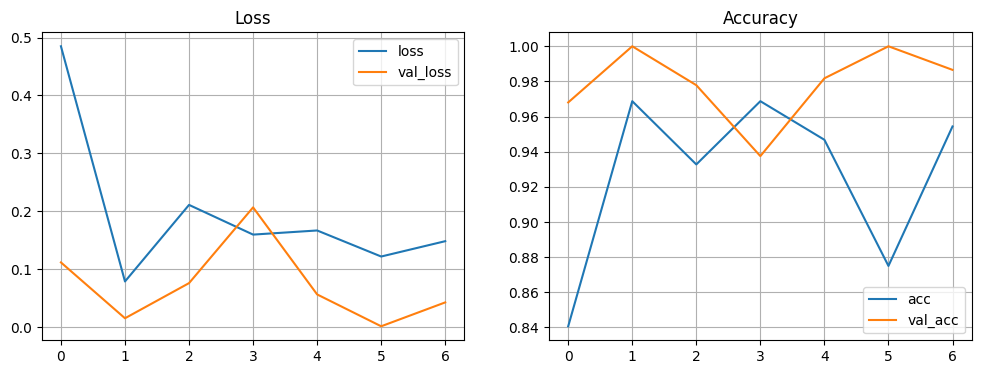

In [21]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)

# harder to overfit
plot_metrics(metrics)

In [22]:
model = cnn_model()
# can recalculate steps_per_epoch to be 60000/32 instead of 50000/32
model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=10)

Epoch 1/10


c:\Users\Sammy Guru\Documents\github\AI-Samir-Ibrahim-OPA23\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


  10/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - acc: 0.1199 - loss: 2.6933

c:\Users\Sammy Guru\Documents\github\AI-Samir-Ibrahim-OPA23\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - acc: 0.6971 - loss: 0.9049
Epoch 2/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9210 - loss: 0.2471  
Epoch 3/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 3:50 148ms/step - acc: 0.8438 - loss: 0.4840

C:\Users\Sammy Guru\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - acc: 0.9263 - loss: 0.2343
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.9455 - loss: 0.1696  
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9463 - loss: 0.1697
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9539 - loss: 0.1473  
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9524 - loss: 0.1486
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.9581 - loss: 0.1290  
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - acc: 0.9594 - loss: 0.1305
Epoch 10/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.9656 - loss: 0.1110  


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([[4.44262866e-08, 9.19481948e-08, 1.86641082e-05, ...,
        9.99980092e-01, 7.16376007e-08, 4.73382556e-07],
       [2.67147698e-06, 2.22345557e-06, 9.99987602e-01, ...,
        4.93996822e-07, 6.38287759e-07, 1.35247964e-08],
       [8.01166919e-08, 9.99989510e-01, 2.66184985e-09, ...,
        1.31111575e-08, 4.19187108e-06, 1.39523166e-07],
       ...,
       [2.83462628e-11, 7.10389803e-11, 2.01505368e-10, ...,
        3.46955631e-10, 2.77077703e-07, 1.86573652e-06],
       [1.76301376e-06, 1.17784241e-10, 3.21357376e-08, ...,
        2.08052882e-07, 6.82018799e-06, 1.51507866e-05],
       [3.16657975e-06, 1.42613006e-08, 6.67301947e-06, ...,
        1.34969458e-08, 1.81874168e-06, 3.67102757e-06]], dtype=float32)

In [24]:
y_pred[0], y_test[0]

(array([4.4426287e-08, 9.1948195e-08, 1.8664108e-05, 4.6320983e-07,
        7.9656388e-08, 4.0800883e-09, 4.8174260e-12, 9.9998009e-01,
        7.1637601e-08, 4.7338256e-07], dtype=float32),
 7)

In [25]:
y_pred[50], y_test[50]

(array([6.6221349e-07, 4.0104760e-09, 1.9192854e-08, 3.2069580e-09,
        1.3587419e-07, 1.0583447e-07, 9.9999845e-01, 7.3545796e-12,
        6.5955311e-07, 2.7189406e-08], dtype=float32),
 6)

In [26]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.98      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



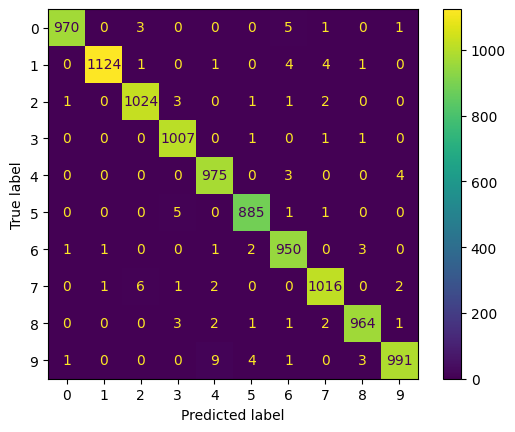

In [28]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()